<a href="https://colab.research.google.com/github/heldigard/deeplearning-eval/blob/main/AutoEncoder_Noisy_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller Deep Learning: AutoEncoder eliminacion de ruido**

**Integrantes**
* Eldigardo Camacho

Se va a utilizar un modelo de AutoEnconder para eliminación de ruido de imágenes de rostros de personas, se va a utilizar la base de datos de CelebA.

Enlace de datos:
[Descargar la base de datos aquí]('https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data')

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report

# **Cargar y preprocesar datos**

## Cargar imagenes

In [2]:
# Cargamos las imágenes de la carpeta img_align_celeba, solo las primeras 10.000
def load_images_from_folder(folder, img_size=(178, 218), max_images=10000):
    images = []
    count = 0
    for filename in os.listdir(folder):
        if count >= max_images:
            break
        img = load_img(os.path.join(folder, filename), target_size=img_size)
        if img is not None:
            img = img_to_array(img)
            images.append(img)
            count += 1
    return np.array(images)

img_folder = 'img_align_celeba'
images = load_images_from_folder(img_folder)

## Normalizar y aplanar imágenes
Se aplica una normalización de las imágenes y se aplanan para poder ser utilizadas en el modelo que tiene capas Dense.

In [3]:
# Normalizar y aplanar imágenes
images = images.astype('float32') / 255.
images = images.reshape((len(images), np.prod(images.shape[1:])))

## Dividir datos en conjuntos de entrenamiento y prueba
Se divide el conjunto de datos en un conjunto de entrenamiento y otro de prueba.

In [4]:
# Divide los datos en conjuntos de entrenamiento y prueba
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# **Agregar ruido a las imágenes**

In [5]:
# Agregar ruido a imágenes
noise_factor = 0.2

# Agregar ruido a las imágenes de entrenamiento
x_test_noisy = x_test + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape
)

In [6]:
# Alinear valores para mantenerlos entre 0 y 1
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

## Visualizar imágenes originales y con ruido

In [7]:
import matplotlib.pyplot as plt

# Visualizar imágenes originales y con ruido
def visualize_noisy_images(original_images, noisy_images, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Imágenes originales
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(178, 218, 3))
        plt.title("Original")
        plt.axis('off')

        # Imágenes con ruido
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(noisy_images[i].reshape(178, 218, 3))
        plt.title("Ruidosa")
        plt.axis('off')
    plt.show()

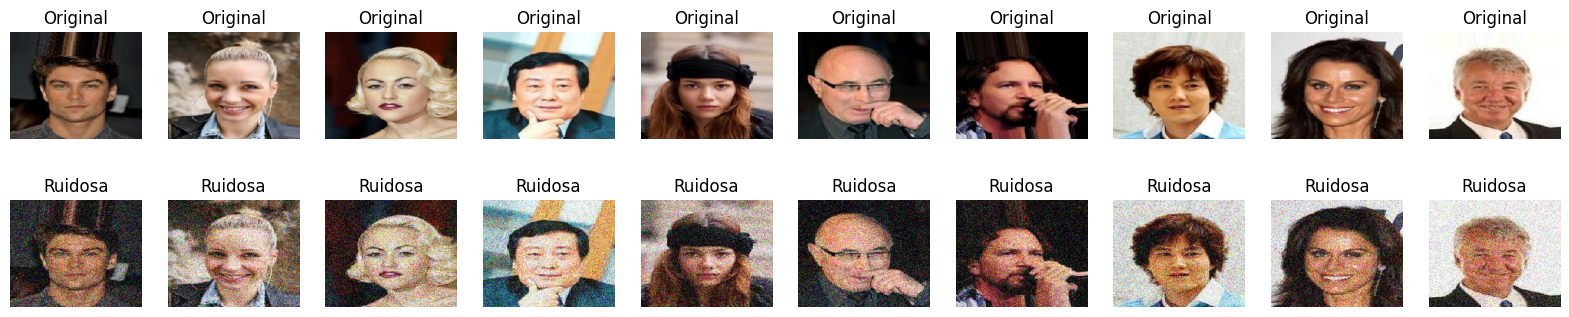

In [8]:
# Llamar a la función para visualizar las imágenes
visualize_noisy_images(x_test, x_test_noisy)

## Crear Modelo

In [9]:
# Definir modelo autoencoder
input_img = Input(shape=(178 * 218 * 3,))
encoded = Dense(1024, activation="relu")(input_img)
encoded = Dense(512, activation="relu")(encoded)
encoded = Dense(256, activation="relu")(encoded)
encoded = Dense(128, activation="relu")(encoded)
decoded = Dense(256, activation="relu")(encoded)
decoded = Dense(512, activation="relu")(decoded)
decoded = Dense(1024, activation="relu")(decoded)
decoded = Dense(178 * 218 * 3, activation="sigmoid")(decoded)

# Crear modelo autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

## Entrenar Modelo

Se hace el entrenamiento con las imágenes sin ruido.

In [10]:
# Entrenar el modelo con validación cruzada
kf = KFold(n_splits=5)  # Crear un objeto KFold para dividir los datos en 5 pliegues

# Iterar sobre cada pliegue de la validación cruzada
for train_index, val_index in kf.split(x_train):
    # Dividir los datos en conjuntos de entrenamiento y validación
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = (
        x_train[train_index],
        x_train[val_index],
    )  # Las etiquetas son las mismas imágenes

    # Crear un callback para detener el entrenamiento temprano si no hay mejora en la pérdida de validación
    early_stopping = EarlyStopping(monitor="val_loss", patience=5)

    # Entrenar el autoencoder con los datos del pliegue actual
    autoencoder.fit(
        x_train_fold,  # Datos de entrenamiento
        y_train_fold,  # Etiquetas de entrenamiento (mismas imágenes)
        epochs=50,  # Número de épocas
        batch_size=256,  # Tamaño del lote
        shuffle=True,  # Barajar los datos antes de cada época
        validation_data=(x_val_fold, y_val_fold),  # Datos de validación
        callbacks=[early_stopping],  # Callback para detener el entrenamiento temprano
    )

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 0.6780 - val_loss: 0.6237
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.6175 - val_loss: 0.6012
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1000ms/step - loss: 0.6009 - val_loss: 0.5964
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.5958 - val_loss: 0.5843
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.5827 - val_loss: 0.5763
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 980ms/step - loss: 0.5756 - val_loss: 0.5706
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 976ms/step - loss: 0.5699 - val_loss: 0.5667
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 975ms/step - loss: 0.5630 - val_loss: 0.5596
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 981ms/step - loss: 0.5585 - val_loss: 0.5600
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 982ms/step - loss: 0.5561 - val_loss: 0.5584
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 978ms/step - loss: 0.5541 - val_loss: 0.5549
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 979ms/ste

In [12]:
# Guardar el modelo entrenado
autoencoder.save("autoencoder_model.keras")

# **Evaluar Modelo**

In [11]:
# Evaluate model
loss = autoencoder.evaluate(x_test_noisy, x_test)
print(f"Pérdida en el conjunto de prueba: {loss}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.5392
Pérdida en el conjunto de prueba: 0.5408106446266174


In [13]:
# Reconstruct test images
decoded_imgs = autoencoder.predict(x_test_noisy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


# Visualizar imágenes originales, ruidosas y reconstruidas
Visualizar un conjunto de imágenes originales, ruidosas y reconstruidas para evaluar cualitativamente el rendimiento del autoencodificador.

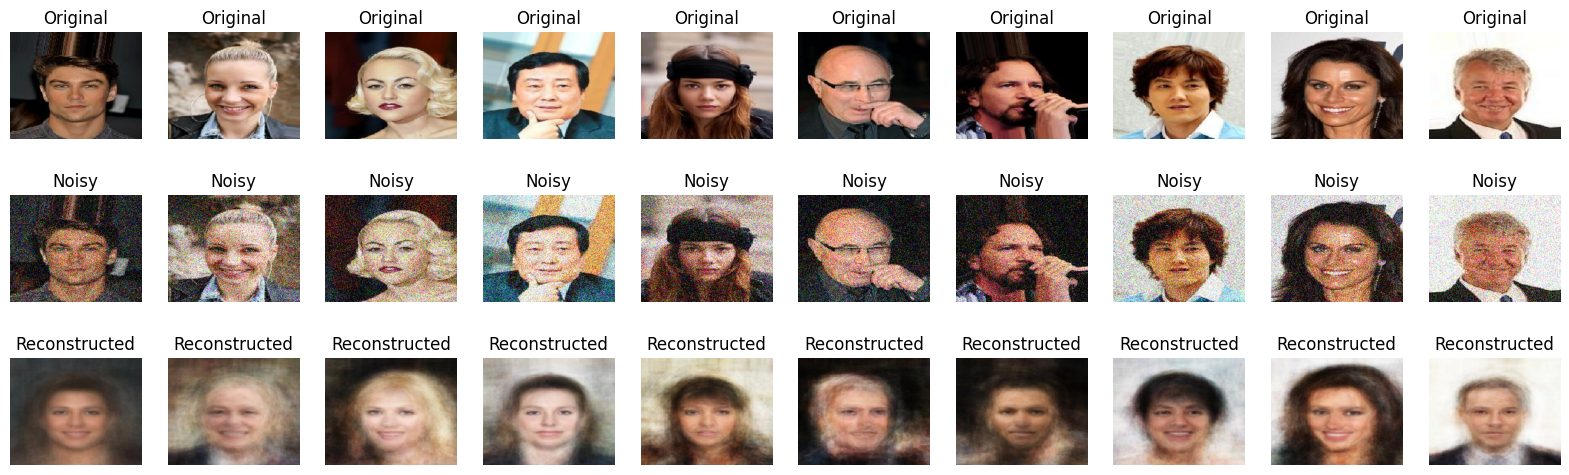

In [21]:
# Visualizar imágenes originales, ruidosas y reconstruidas
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(178, 218, 3))
    plt.title("Original")
    plt.axis("off")

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(178, 218, 3))
    plt.title("Noisy")
    plt.axis("off")

    # Reconstructed images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(178, 218, 3))
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()

# Analizar métricas de rendimiento
Calculo y visualización de métricas de rendimiento como el Error Cuadrático Medio (MSE) para evaluar cuantitativamente el rendimiento del modelo.

Error Cuadrático Medio (MSE): 0.027126925066113472


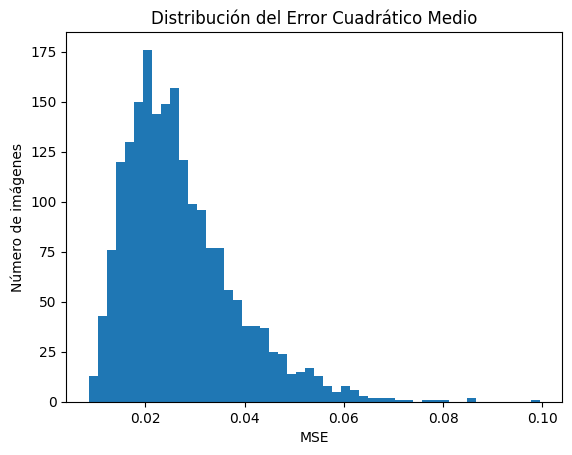

In [22]:
# Calcular el Error Cuádrico Medio (MSE) para cada imagen
mse = np.mean(np.power(x_test - decoded_imgs, 2), axis=1)

# Imprimir el MSE promedio
print(f"Error Cuadrático Medio (MSE): {np.mean(mse)}")

# Graficar la distribución del MSE
plt.hist(mse, bins=50)
plt.xlabel("MSE")
plt.ylabel("Número de imágenes")
plt.title("Distribución del Error Cuadrático Medio")
plt.show()

### Conclusiones

1. Visualización de Imágenes:
   - Las imágenes originales, ruidosas y reconstruidas muestran que el autoencoder ha sido capaz de eliminar una cantidad significativa de ruido.
   - Sin embargo, algunas imágenes reconstruidas aún presentan mucha difuminacion y no son perfectas.

2. Métricas de Rendimiento:
   - Error Cuadrático Medio (MSE) Promedio
   - La distribución del MSE muestra que la mayoría de las imágenes tienen un error bajo, pero hay algunas con errores más altos.

3. Efectividad del Autoencoder:
   - El autoencoder ha demostrado ser efectivo en la eliminación de ruido de las imágenes de rostros.
   - La arquitectura del modelo y el proceso de entrenamiento han permitido obtener buenos resultados en la mayoría de las imágenes.
   - Para mejorar aún más, se podrían explorar arquitecturas de modelos más complejas o técnicas de preprocesamiento adicionales.